# In class exercises for 11.21.2018 (Filtering)

## First import data from eeg_data00.npz

In [19]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import our sinc filter implementation function...
import my_sinc_filt as msf

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [3]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

Shape of the big eeg data set:  (960, 876)
Sample rate:  250


## Extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

In [4]:
seg_data = data[:,(tx>=0)  & (tx<2000)]
seg_time = tx[(tx>=0) & (tx<2000)]

## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

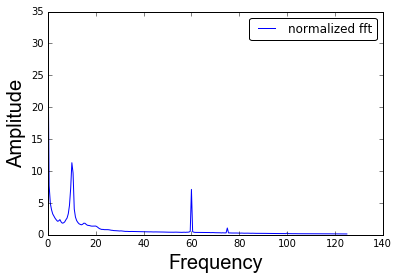

In [5]:
r,c = seg_data.shape

sp = np.fft.rfft(seg_data, axis=1)                    # compute FFT

# compute amplitude
amp = (np.abs(sp) / c) *2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial

In [6]:
fc=0.1
b=0.1
win = 'blackman'
type_filt = 'lp'

# make our function call to generate a lp filter
n, sinc_func = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

# filter the signal
filt_sig = np.zeros((r,c))
for i in np.arange(r):
    filt_sig[i,:] = msf.apply_filt(input_sig=seg_data[i,:], input_filter=sinc_func)

## Then FFT it again to see if you got rid of the hf components of the signal

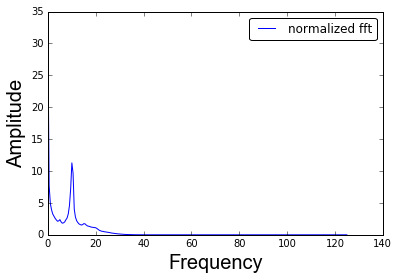

In [7]:
r,c = filt_sig.shape

# compute FFT - all trials at once
sp = np.fft.rfft(filt_sig, axis=1)                    

# compute amplitude
amp = (np.abs(sp) / c) * 2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter (with an appropriate fc), then make a hp filter (with an appropriate fc)
* For fun use np.convolve to combine the two filters (instead of multiply in frequ domain) 
* Then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

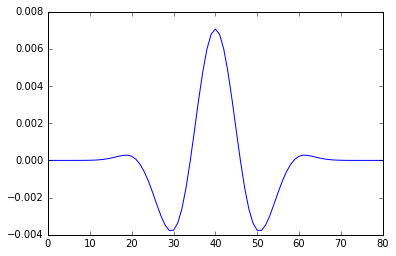

In [20]:
# figure out our target fc given a desired band pass range
bp_range = [6, 14]
# convert from Hz to fc
fcs = bp_range/sr  

# build the low pass filter
fc=fcs[0]
b=0.1
win = 'blackman'
type_filt = 'lp'

# make our function call to generate a lp filter
n, sinc_func_lp = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

# now make the hp filter
fc=fcs[1]
b=0.1
win = 'blackman'
type_filt = 'hp'

# make our function call to generate a hp filter
n, sinc_func_hp = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

# now convolve the two filters
bp_filt = np.convolve(sinc_func_lp,sinc_func_hp)
plt.plot(bp_filt)

# filter the signal
filt_sig = np.zeros((r,c))
for i in np.arange(r):
    filt_sig[i,:] = msf.apply_filt(input_sig=seg_data[i,:], input_filter=bp_filt)

## Then FFT and look at filtered signal in the frequency domain

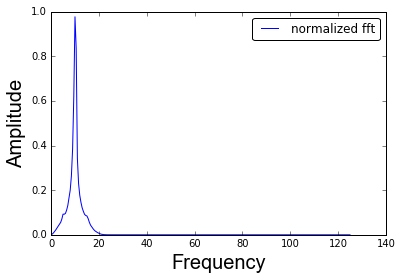

In [21]:
r,c = filt_sig.shape

# compute FFT - all trials at once
sp = np.fft.rfft(filt_sig, axis=1)                    

# compute amplitude
amp = (np.abs(sp) / c) * 2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

## You can also make a band-stop filter using a similar logic
* Instead of convolving the lp and the hp filters, you can add them together
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

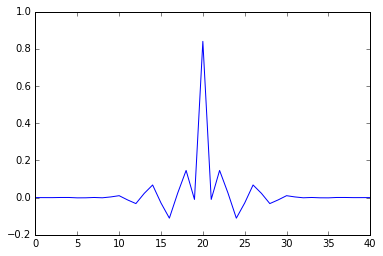

In [22]:
# figure out our target fc given a desired band pass range
bstop_range = [50,70]
# convert from Hz to fc
fcs = bstop_range/sr  

# build the low pass filter
fc=fcs[0]
b=0.1
win = 'blackman'
type_filt = 'lp'

# make our function call to generate a lp filter
n, sinc_func_lp = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

# now make the hp filter
fc=fcs[1]
b=0.1
win = 'blackman'
type_filt = 'hp'

# make our function call to generate a hp filter
n, sinc_func_hp = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

# now add the two filters
bstop_filt = sinc_func_lp+sinc_func_hp
plt.plot(bstop_filt)

# filter the signal
filt_sig = np.zeros((r,c))
for i in np.arange(r):
    filt_sig[i,:] = msf.apply_filt(input_sig=seg_data[i,:], input_filter=bstop_filt)

## Then FFT and look at filtered signal in the frequency domain

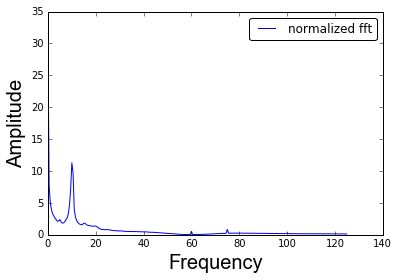

In [23]:
r,c = filt_sig.shape

# compute FFT - all trials at once
sp = np.fft.rfft(filt_sig, axis=1)                    

# compute amplitude
amp = (np.abs(sp) / c) * 2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()